# Language Transformers for IMDB Reviews

In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, dataset
from torch.nn.utils.rnn import pad_sequence

from torchtext.datasets import IMDB
from torchtext.vocab import build_vocab_from_iterator 
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

import matplotlib.pyplot as plt
import numpy as np

Get data

In [44]:
# Get train and test datasets of IMDB reviews
train_iter, test_iter = IMDB(split=('train', 'test'))

# Convert iterable-style dataset to map-style dataset
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Split the train data to train and validation
g = torch.Generator().manual_seed(0)
split_percentage = 0.9
num_train = int(len(train_dataset) * split_percentage)
train_dataset, validation_dataset = dataset.random_split(train_dataset, [num_train, len(train_dataset) - num_train], generator=g)

print('Size of the train set: ', len(train_dataset))
print('Size of the validation set : ', len(validation_dataset))
print('Size of the test set: ', len(test_dataset))

Size of the train set:  22500
Size of the validation set :  2500
Size of the test set:  25000


In [45]:
# Get tokenizer
tokenizer = get_tokenizer("basic_english") 

# TODO: Choose sentences to see their tokenization
ind = 7

print("label: ", train_dataset[ind][0])
print('%--------Original sentence--------%')
print(train_dataset[ind][1])
print('\n%--------Tokenized sentence--------%')
print(tokenizer(train_dataset[ind][1]))

label:  2
%--------Original sentence--------%
Perhaps the funniest 'backstage at Hollywood' movie ever, especially for a look at comedy short factories like Keystone.<br /><br />Marion Davies should get a medal for bravery for taking a part where acting poorly in front of a camera is part of the role. Plenty of cameos for film buffs.

%--------Tokenized sentence--------%
['perhaps', 'the', 'funniest', "'", 'backstage', 'at', 'hollywood', "'", 'movie', 'ever', ',', 'especially', 'for', 'a', 'look', 'at', 'comedy', 'short', 'factories', 'like', 'keystone', '.', 'marion', 'davies', 'should', 'get', 'a', 'medal', 'for', 'bravery', 'for', 'taking', 'a', 'part', 'where', 'acting', 'poorly', 'in', 'front', 'of', 'a', 'camera', 'is', 'part', 'of', 'the', 'role', '.', 'plenty', 'of', 'cameos', 'for', 'film', 'buffs', '.']


Build a vocabulary

In [46]:
# Set the maximal number of distinct tokens in the vocabulary
max_num_tokens = int(5e4)

# Define an iterator that yields the tokens
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text) 

# Define a function that build a vocabulary from dataset
def get_vocab(train_datapipe, _max_tokens=None): 
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<pad>","<unk>"], max_tokens=_max_tokens)
    vocab.set_default_index(vocab["<unk>"]) 
    return vocab

# Get the vocabulary for the IMDB training set
vocab = get_vocab(train_iter, max_num_tokens)

print('Size of the vocabulary: ', len(vocab))

Size of the vocabulary:  50000


In [47]:
vocab["<pad>"]

0

Define a function that tokenize a batch on the fly during training

In [48]:
# Define a function that gets a batch of reviews with labels and tokenize them
def collate_batch(batch):

    # Initialize lists for labels and text for the reviews
    label_list, text_list = [], []
  
    for (_label, _text) in batch: # for each review in the batch
        label_list.append(_label-1) # Change the labels from {1,2} to {0,1} for binary classification and append it to the list
        tokens = tokenizer(_text) # Get the tokens for the current review
        tokens_indices = torch.LongTensor(vocab(tokens)) # Get the indices of the tokens in type 'Long'
        text_list.append(tokens_indices) # Append the indices of the tokes to the list, note that for each review the number of tokens can be different

    # Convert the list of labels to torch Tensor of type 'Long'
    labels = torch.LongTensor(label_list)
    
    # TODO: Pad all the reviews to the same length to form a torch Tensor of samples.
    # Use the pad_sequence of torchtext and set padding_value properly. Note that batch_first should be true
    samples = pad_sequence(text_list, True, 0)

    # Return the samples and their corresponding labels
    return labels, samples

Define the dataloaders for the training, validation and test sets

In [49]:
batch_size = 16
num_workers = 4
train_dataloader = DataLoader(train_dataset, num_workers=num_workers, persistent_workers=True, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, num_workers=num_workers, persistent_workers=True, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=False)

To the initial input of the network we add positional encoding, such that the attention mechanism will know from which location in the sequence (text) the token is. 

In [50]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # Create a long enough `P`
        self.register_buffer('P', torch.zeros((1, max_len, num_hiddens)))

        X = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        # X = i
        # max_len = l
        # TODO: Compute the argument of the sine and cosine with the formula given in the preparation
        J = torch.arange(0, int((num_hiddens-1)/2) + 1, dtype=torch.float32).unsqueeze(0)
        X = X / (10000**(2*J/num_hiddens))
        
        # The even entries of P get sine while the odd get cosine
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X)

In [51]:
num_hiddens=20
max_len=1000
X = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
print(X.shape)

J= torch.arange(0, int((num_hiddens-1)/2) + 1, dtype=torch.float32).unsqueeze(0)
print(J.shape)
X / (10000**(2*J/num_hiddens))

torch.Size([1000, 1])
torch.Size([1, 10])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 3.9811e-01, 1.5849e-01,  ..., 1.5849e-03, 6.3096e-04,
         2.5119e-04],
        [2.0000e+00, 7.9621e-01, 3.1698e-01,  ..., 3.1698e-03, 1.2619e-03,
         5.0238e-04],
        ...,
        [9.9700e+02, 3.9691e+02, 1.5801e+02,  ..., 1.5801e+00, 6.2906e-01,
         2.5044e-01],
        [9.9800e+02, 3.9731e+02, 1.5817e+02,  ..., 1.5817e+00, 6.2970e-01,
         2.5069e-01],
        [9.9900e+02, 3.9771e+02, 1.5833e+02,  ..., 1.5833e+00, 6.3033e-01,
         2.5094e-01]])

Example for positional encoding

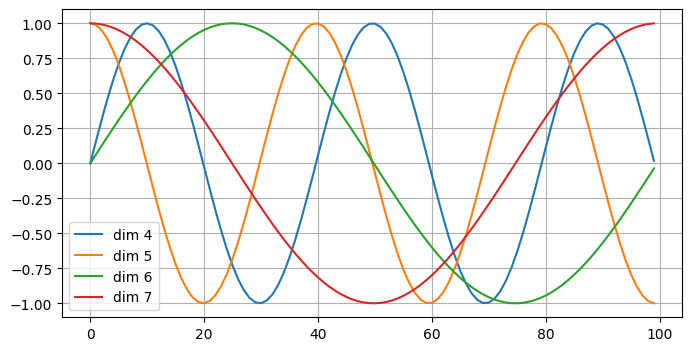

In [52]:
"""
Test the PositionalEncoding class with a toy model for 4 dimensions. 
The  1st  dimension has the same frequency as the 2nd but with different offset (i.e. phase)
because one is produced by a sine function and the other is produced by a cosine function. 
The  3rd  and  4th  dimensions have higher frequency.
"""
num_hiddens = 20
pe = PositionalEncoding(num_hiddens=num_hiddens, dropout=0, max_len=100)
pe.eval()
Y = pe(torch.zeros((1, 100, num_hiddens))).cpu().numpy()  # 1 example, 100 tokens with embedding dim of 20
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for p in [4,5,6,7]:
    ax.plot(np.arange(100), Y[0, :, p].T, label=f'dim {p}')
ax.legend()
ax.grid()

Define the embeddings of the tokens in the vocabulary

In [53]:
# Embeddings class: sequences -> features
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()

        # Attach parameters to the module
        self.dropout = dropout
        self.d_model = d_model

        # TODO: Create the embeddings for the tokens in the vocabulary and set the padding_idx to 0, which is vocab['<pad>']
        self.word_embeddings = torch.nn.Embedding(vocab_size,d_model,padding_idx=0)

        # TODO: Create the positional encoding layer, note that num_hiddens=d_model
        self.position_encoding = PositionalEncoding(num_hiddens=d_model, dropout=dropout, max_len=max_position_embeddings)

        # Create a normalization layer
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):

        # TODO: Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)
        
        # TODO: Add positional encoding to the word embeddings
        embeddings_with_encoding = self.position_encoding(word_embeddings)
        
        # Normalize the embeddings
        embeddings = self.LayerNorm(embeddings_with_encoding)
        return embeddings

Define a layer for multi-head attention

In [54]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        # each head has hidden dimension d_k
        self.d_k = d_model // self.num_heads # here d is divided between the heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)

        # Softmax
        self.softmax = nn.Softmax(dim=3)
        
    def scaled_dot_product_attention(self, Q, K, V):
        
        # TODO: Get the matching scores between the quarries and keys.
        # Note that the dimension of Q are (bs, n_heads, q_length, dim_per_head),
        # and the dimension of K are (bs, n_heads, k_length, dim_per_head).
        scores = K.transpose(2,3)@Q
        
        # Divide the scores by square root of d_k, so that the soft(arg)max doesn't saturate
        scores = scores.div(np.sqrt(self.d_k))

        # TODO: Apply softmax to the scores to get the attention map A
        A = self.softmax(scores)

        # Apply dropout to attention map A
        A = self.dropout(A)
        
        # TODO:  Get the weighted average of the values V using the attention map A
        H = V@A

        return H, A 

        
    def split_heads(self, x, batch_size):
        """ Split the last dimension into (heads X depth)
            Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k) """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)


    def group_heads(self, x, batch_size):
        """ Combine the heads again to get (batch_size X seq_length X (num_heads times d_k)) """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size = X_q.shape[0]

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)
        
        # Final linear layer
        H = self.W_h(H_cat)
        
        return H, A

#### Self-Attention Sanity Check

If the query matches with one of the key values, it should have all the attention focused there, with the value returned as the value at that index.

In [55]:
# Set the dimension d
d = 512

# TODO: Create a multi-head attention layer with dimension d, 8 heads and with no dropout
temp_mha = MultiHeadAttention(d_model=d, num_heads=8, dropout=0)

# Create a random orthogonal matrix U s.t. U^T U = U U^T = I
U, S, Rh = torch.linalg.svd(torch.randn(d,d))

# Set the keys and quarries to be U
test_Q = test_K = d*U[None, None]

# Create random values
V = torch.randn(d,d)
test_V = V[None, None]

temp_out, temp_attn = temp_mha.scaled_dot_product_attention(test_Q, test_K, test_V)
print('Values are:\n', V)
print('Attention weights are:\n', temp_attn.squeeze())
print('Output is:\n', temp_out.squeeze())

Values are:
 tensor([[-0.3170,  0.6137,  0.6825,  ..., -0.6443, -0.4211,  0.3704],
        [ 0.5378,  1.2864,  0.3646,  ..., -0.7596,  0.8870, -1.3230],
        [ 0.2429, -0.6758, -0.0179,  ..., -0.8331, -1.1670, -1.5273],
        ...,
        [-1.8904, -0.5903,  1.3053,  ..., -0.3233,  1.5448,  0.5697],
        [ 0.2101,  0.3405,  0.5070,  ..., -0.1221, -0.2632,  0.5185],
        [ 0.4353,  1.2919,  0.0177,  ...,  0.2559,  0.4372, -0.6210]])
Attention weights are:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Output is:
 tensor([[-0.3170,  0.6137,  0.6825,  ..., -0.6443, -0.4211,  0.3704],
        [ 0.5378,  1.2864,  0.3646,  ..., -0.7596,  0.8870, -1.3230],
        [ 0.2429, -0.6758, -0.0179,  ..., -0.8331, -1.1670, -1.5273],
        ...,
        [-1.8904, -0.5903,  1.3053,  ...

After attention we use a feed forward network, usually multi-layer perceptron (MLP)

In [56]:
class FFN(nn.Module):
    """ Feed Forward Network (FFN): an MLP with one hidden layer and ReLU activation applied to each and every element in the set. """
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.Layer1 = nn.Linear(d_model, hidden_dim)
        self.Layer2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.Layer1(x)
        x = self.activation(x)
        x = self.Layer2(x)
        return x

Now we are ready to define the standard block of the encoder transformer

In [57]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):
        super().__init__()
        
        # Attach parameter to the module
        self.dropout = dropout

        # Create the multi-head attention layer
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)

        # Create the feed-forward neural network 
        self.ffn = FFN(d_model, conv_hidden_dim)

        # Create the normalization layers
        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)


        
    
    def forward(self, x):
        
        # TODO:Apply multi-head *self*-attention, note that the attention maps can be discarded 
        attn_output, _ = self.mha(x,x,x)

        # TODO: Layer norm after adding the residual connection
        out1 = self.layernorm1(attn_output + x)
        
        # TODO: Apply a feed forward network
        ffn_output = self.ffn(out1)
        
        # TODO: Apply a second layer norm after adding residual connection 
        out2 = self.layernorm2(ffn_output + out1)

        return out2

Using the blocks above we define the transformer encoder

In [58]:

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, dropout=0.1):
        super().__init__()

        # Attach parameters to the module
        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = dropout

        # Create the embedding layer
        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, dropout)

        # Create the encoder blocks 
        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderBlock(d_model, num_heads, ff_hidden_dim, self.dropout))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

Finally we define the transformer classifier for sentiment analysis

In [59]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                                          maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        
        # Process the sequence
        x = self.encoder(x)  # [batch_size, seq_len, d_model]

        # Get a final value from the sequence in a form of a mean value
        x = x.mean(dim=1) # [batch_size, d_model]

        #----------------Alternatives for taking the mean----------------#
        # Taking the maximum value
        # x, _ = torch.max(x, dim=1)

        # Taking the dominant value
        # _ , inds_abs = torch.max(x.abs(), dim=1)
        # x = torch.gather(x, dim=1, index=inds_abs.unsqueeze(1)).squeeze()

        # Taking the last value of the sequence, which should hold the information
        # x = x[:, -1]

        # Classify according to the final value
        x = self.dense(x)  # [batch_size, num_answers]
        
        return x

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and send it to the working device
model = TransformerClassifier(num_layers=2, d_model=16, num_heads=2, conv_hidden_dim=16, input_vocab_size=max_num_tokens, num_answers=2)
model.to(device)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 12

# Define the criterion to be optimized
criterion = nn.CrossEntropyLoss()

In [61]:
# Evaluation function for validation and test sets
def evaluate(data_loader):
    n_samples = len(data_loader.dataset)
    model.eval()
    acc = torch.zeros([]) 
    with torch.no_grad():
        for (label, text) in data_loader:
            x = text.to(device)
            y = label.to(device)
                    
            out = model(x)
            acc += (out.argmax(dim=1) == y).cpu().numpy().sum()
            torch.cuda.empty_cache()
    print(f"eval accuracy: {acc / n_samples}")

In [62]:
# Training function
def train(train_loader, valid_loader):
    for epoch in range(epochs):
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for (label, text) in train_loader:
            optimizer.zero_grad()

            x = text.to(device)
            y = label.to(device)
            out = model(x)

            loss = criterion(out, y)
            loss.backward()
            losses += loss.item()

            optimizer.step()
                        
            train_acc += (out.argmax(dim=1) == y).cpu().numpy().mean()
            torch.cuda.empty_cache()
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        print(f"training accuracy: {train_acc / nb_batches_train}")
        print('evaluating on validation:')
        evaluate(valid_loader)

In [63]:
train(train_dataloader, validation_dataloader)

epoch 0: train loss: 0.6913201649955462
training accuracy: 0.5209370554765291
evaluating on validation:
eval accuracy: 0.5091999769210815
epoch 1: train loss: 0.6278638349233956
training accuracy: 0.6523826458036984
evaluating on validation:
eval accuracy: 0.7396000027656555
epoch 2: train loss: 0.5402434040735321
training accuracy: 0.7290629445234709
evaluating on validation:
eval accuracy: 0.7396000027656555
epoch 3: train loss: 0.48464083741518377
training accuracy: 0.7644025604551921
evaluating on validation:
eval accuracy: 0.7423999905586243
epoch 4: train loss: 0.43839319191798887
training accuracy: 0.7996532716927454
evaluating on validation:
eval accuracy: 0.758400022983551
epoch 5: train loss: 0.4030212460305664
training accuracy: 0.8174342105263158
evaluating on validation:
eval accuracy: 0.7964000105857849
epoch 6: train loss: 0.3706907597801
training accuracy: 0.8394381223328592
evaluating on validation:
eval accuracy: 0.8059999942779541
epoch 7: train loss: 0.3401392828885

In [64]:
evaluate(test_dataloader)

eval accuracy: 0.8142399787902832
